# Có 5 loại cổ phiếu cần forcasting: 'ACB', 'BID', 'VCB', 'MBB', 'FPT' có trong 2 file csv là stock_data_2025_raw.csv và stock_data_2025_with_indicators.csv (có nhiều feature hơn)

giờ trong mỗi file csv tôi muốn chia ra 5 nhóm cổ phiếu riêng để training mô hình forcasting theo time series với các window_size(3, 7, 14,30, 90)
Trong giai đoạn training, mô hình được huấn luyện trên các đoạn dữ liệu (window) có độ dài cố định window_size.

Mỗi đoạn (window) gồm window_size quan sát liên tiếp trong quá khứ, được dùng để dự đoán giá trị ở bước kế tiếp (+1 ngày).

Trong giai đoạn forecasting (test), mô hình bắt đầu với window_size điểm dữ liệu cuối cùng của tập huấn luyện để dự đoán giá trị tiếp theo.
Sau mỗi lần dự đoán, giá trị dự đoán mới được thêm vào cuối cửa sổ và loại bỏ điểm đầu tiên, tạo thành một “rolling window” mới để dự đoán bước kế tiếp.
Quá trình này được lặp lại cho đến khi đạt số lượng bước dự báo mong muốn (multi-step recursive forecast).

# Machine Learning Models for Time Series Forecasting
ml_models = [
    "LinearRegression",       # baseline tuyến tính, dễ giải thích
    "Ridge",                  # regularized linear regression
    "Lasso",                  # feature selection + regularization
    "ElasticNet",             # mix giữa L1 và L2 regularization
    "DecisionTreeRegressor",  # mô hình cây, dễ hiểu, non-linear
    "RandomForestRegressor",  # ensemble mạnh mẽ, giảm overfit
    "ExtraTreesRegressor",    # random forest cải tiến (faster)
    "GradientBoostingRegressor", # boosting cổ điển
    "XGBRegressor",           # XGBoost, mạnh và phổ biến
    "LGBMRegressor",          # LightGBM, nhanh, xử lý large data tốt
    "CatBoostRegressor",      # CatBoost, auto handling categorical
    "KNeighborsRegressor",    # non-parametric, pattern-based
    "SVR",                    # Support Vector Regression, robust
    "KernelRidge",            # ridge với kernel, cho quan hệ phi tuyến
    "AdaBoostRegressor",      # boosting đơn giản, dễ thử baseline
    "BaggingRegressor"        # ensemble method, tăng độ ổn định
]



# Deep Learning Models for Time Series Forecasting
dl_models = [
    "MLP",                    # Multi-Layer Perceptron (feed-forward baseline)
    "LSTM",                   # Long Short-Term Memory — nhớ dài hạn, classic model
    "GRU",                    # Gated Recurrent Unit — nhẹ hơn, nhanh hơn LSTM
    "BiLSTM",                 # Bidirectional LSTM — nhìn cả quá khứ và “tương lai”
    "CNN1D",                  # 1D Convolutional Neural Network — bắt local pattern
    "ConvLSTM",               # CNN + LSTM — local pattern + temporal dependency
    "TCN",                    # Temporal Convolutional Network — thay thế LSTM, song song hơn
    "Seq2Seq",                # Encoder-Decoder (multi-step forecast)
    "AttentionLSTM",          # LSTM kết hợp attention mechanism
    "Transformer",            # base transformer (multi-head attention)
    "Informer",               # efficient transformer cho long sequence
    "TFT",                    # Temporal Fusion Transformer (interpretable)
    "DLinear",                # linear transformer, cực nhanh & hiệu quả (2023+)
    "TimesNet",               # SOTA 2024–2025, mô hình hóa pattern theo frequency
    "NBeats",                 # Neural basis expansion — mạnh, interpretable
    "NHiTS"                   # Improved NBeats — deep forecasting hiện đại
]


In [1]:
# Imports and utilities
import os
import math
import warnings
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Ensure inline plotting in notebooks
# %matplotlib inline  # VS Code usually sets this automatically
plt.rcParams['figure.max_open_warning'] = 0

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

SYMBOLS = ["ACB", "BID", "VCB", "MBB", "FPT"]
WINDOW_SIZES = [3, 7, 14, 30, 90]
TEST_RATIO = 0.2  # last 20% as test by default
SHOW_PLOTS = True  # display figures in notebook output cells

# Metrics

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.mean(np.abs(y_true - y_pred))


def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return math.sqrt(np.mean((y_true - y_pred) ** 2))


def mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(y_true == 0, np.nan, np.abs(y_true))
    out = np.abs((y_true - y_pred) / denom) * 100.0
    return np.nanmean(out)

print("Setup complete. Ready to load data.")

Setup complete. Ready to load data.


In [2]:
# Load CSVs
from pathlib import Path
import os

# In notebooks, __file__ is not defined; use current working directory (VS Code defaults to notebook's folder)
base_dir = Path.cwd()
raw_csv = base_dir / "stock_data_2025_raw.csv"
ind_csv = base_dir / "stock_data_2025_with_indicators.csv"

assert raw_csv.exists(), f"Missing file: {raw_csv}"
assert ind_csv.exists(), f"Missing file: {ind_csv}"

raw = pd.read_csv(raw_csv)
ind = pd.read_csv(ind_csv)

# Normalize columns
for df in (raw, ind):
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
    df.sort_values(['symbol', 'time'], inplace=True)
    df.reset_index(drop=True, inplace=True)

print(raw.head())
print(ind.head())
print({"raw_rows": len(raw), "ind_rows": len(ind), "symbols": sorted(raw['symbol'].unique().tolist())})

        time  open  high   low  close  volume symbol
0 2015-01-05  2.35  2.34  2.31   2.34   55888    ACB
1 2015-01-06  2.32  2.38  2.32   2.37   89802    ACB
2 2015-01-07  2.37  2.44  2.36   2.40  232861    ACB
3 2015-01-08  2.40  2.43  2.40   2.42   14880    ACB
4 2015-01-09  2.42  2.48  2.37   2.43  693623    ACB
        time  open  high   low  close    volume symbol  SMA_5  SMA_10  SMA_20  \
0 2015-01-05  2.35  2.34  2.31   2.34   55888.0    ACB  2.344   2.350  2.3550   
1 2015-01-06  2.32  2.38  2.32   2.37   89802.0    ACB  2.348   2.352  2.3545   
2 2015-01-07  2.37  2.44  2.36   2.40  232861.0    ACB  2.360   2.358  2.3555   
3 2015-01-08  2.40  2.43  2.40   2.42   14880.0    ACB  2.376   2.363  2.3595   
4 2015-01-09  2.42  2.48  2.37   2.43  693623.0    ACB  2.392   2.369  2.3635   

   ...  Donchian_upper  Donchian_middle  Donchian_lower  Ulcer_Index  \
0  ...            2.41            2.360            2.31     1.157757   
1  ...            2.41            2.360            

In [3]:
# Prepare per-symbol datasets and sliding windows

import numpy as np
import pandas as pd
from typing import Tuple, List


def make_supervised(series: pd.Series, window: int) -> Tuple[np.ndarray, np.ndarray]:
    # Fill missing values to avoid NaNs in windows
    s = series.astype(float).copy()
    s = s.ffill().bfill()
    vals = s.values
    X, y = [], []
    for i in range(window, len(vals)):
        window_vals = vals[i - window:i]
        target_val = vals[i]
        X.append(window_vals)
        y.append(target_val)
    X = np.array(X)
    y = np.array(y)
    return X, y


def train_test_split_by_time(df: pd.DataFrame, test_ratio: float = TEST_RATIO) -> Tuple[pd.DataFrame, pd.DataFrame]:
    n = len(df)
    n_test = max(1, int(n * test_ratio))
    return df.iloc[: n - n_test], df.iloc[n - n_test :]


def recursive_forecast(last_window: np.ndarray, steps: int, predict_next_fn) -> List[float]:
    # last_window shape: (window,)
    buf = np.array(last_window, dtype=float).copy()
    preds = []
    for _ in range(steps):
        nxt = float(predict_next_fn(buf))
        preds.append(nxt)
        buf = np.roll(buf, -1)
        buf[-1] = nxt
    return preds

print("Windowing helpers ready.")

Windowing helpers ready.


In [4]:
# Baseline models: Naive (last value), SMA(k), optional LinearRegression / HistGradientBoostingRegressor
try:
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.impute import SimpleImputer
    SKLEARN_AVAILABLE = True
    IMP_AVAILABLE = True
except Exception:
    SKLEARN_AVAILABLE = False
    IMP_AVAILABLE = False

# Optional: gradient boosting that handles NaNs
if SKLEARN_AVAILABLE:
    try:
        from sklearn.ensemble import HistGradientBoostingRegressor
        HGB_AVAILABLE = True
    except Exception:
        HGB_AVAILABLE = False
else:
    HGB_AVAILABLE = False

@dataclass
class ModelSpec:
    name: str
    params: Dict


def fit_naive(X: np.ndarray, y: np.ndarray):
    # For naive, prediction is just last element of window, no fitting needed
    return None


def pred_naive(window_vec: np.ndarray) -> float:
    return float(window_vec[-1])


def fit_sma(X: np.ndarray, y: np.ndarray, k: int):
    # For SMA, prediction is mean of last k items of window
    return {"k": int(k)}


def pred_sma(window_vec: np.ndarray, state: Dict) -> float:
    k = int(state.get("k", len(window_vec)))
    k = max(1, min(k, len(window_vec)))
    return float(np.mean(window_vec[-k:]))


def fit_lr(X: np.ndarray, y: np.ndarray):
    # Use an imputer so LR won't fail on any residual NaNs
    if IMP_AVAILABLE:
        model = make_pipeline(SimpleImputer(strategy="median"), LinearRegression())
    else:
        model = LinearRegression()
    model.fit(X, y)
    return model


def pred_lr(window_vec: np.ndarray, model) -> float:
    return float(model.predict(window_vec.reshape(1, -1))[0])

print("Models wired:", {"sklearn": SKLEARN_AVAILABLE, "hist_gbr": HGB_AVAILABLE, "imputer": IMP_AVAILABLE})

Models wired: {'sklearn': True, 'hist_gbr': True, 'imputer': True}


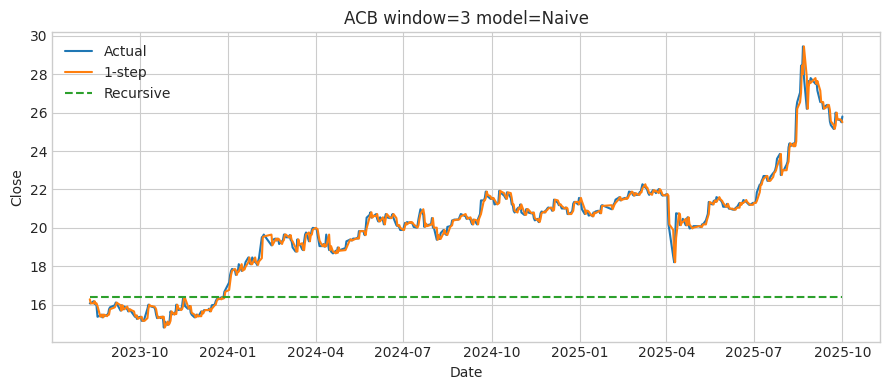

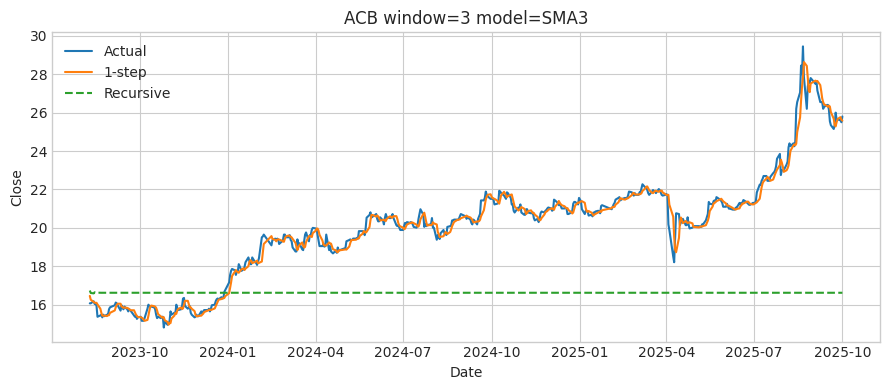

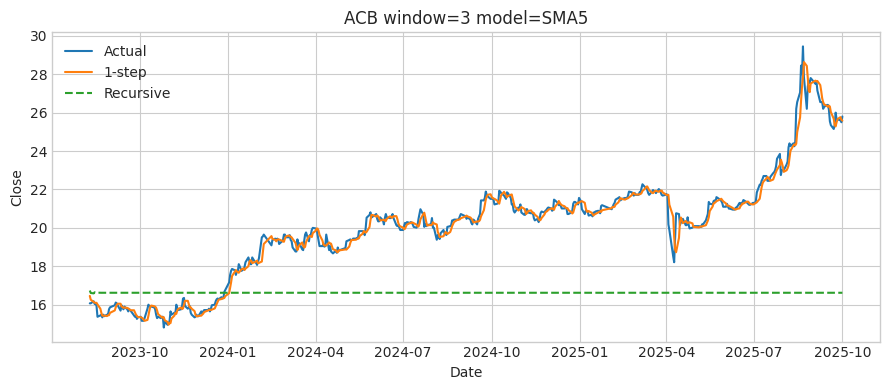

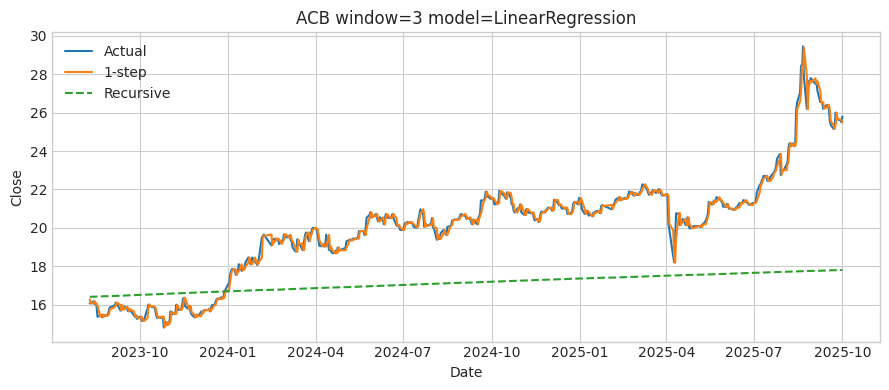

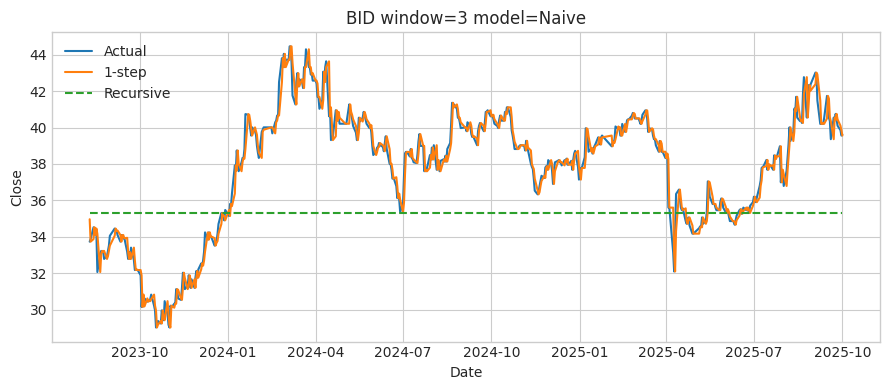

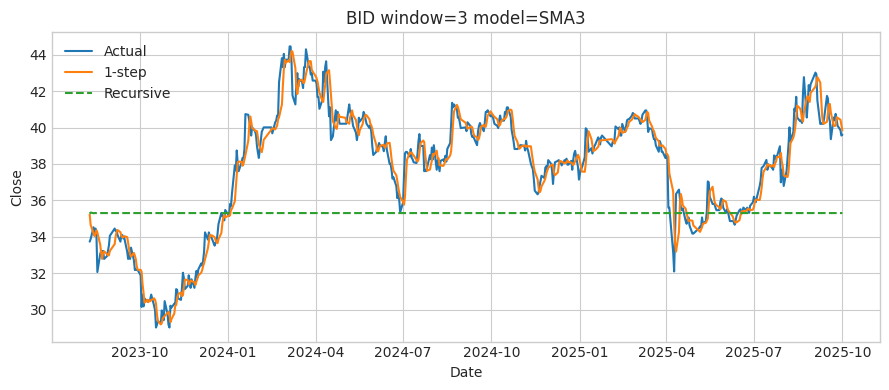

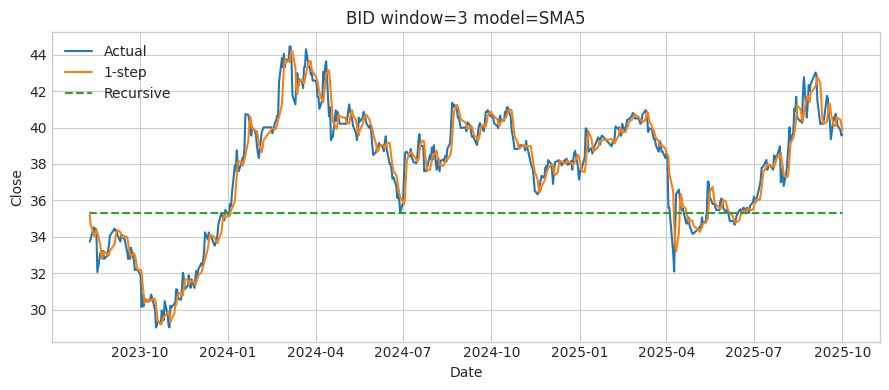

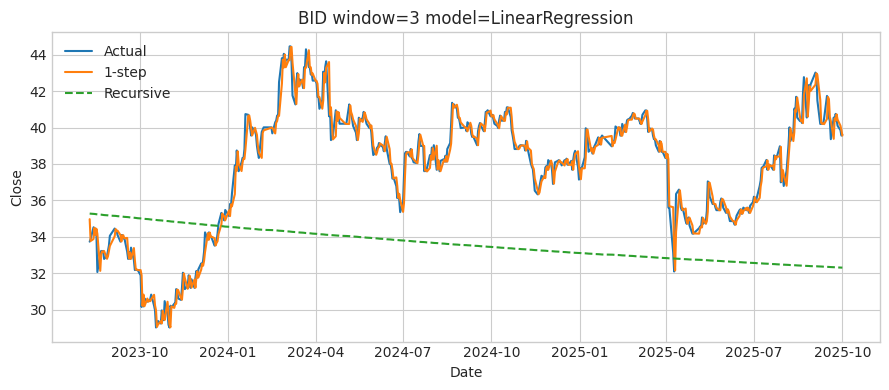

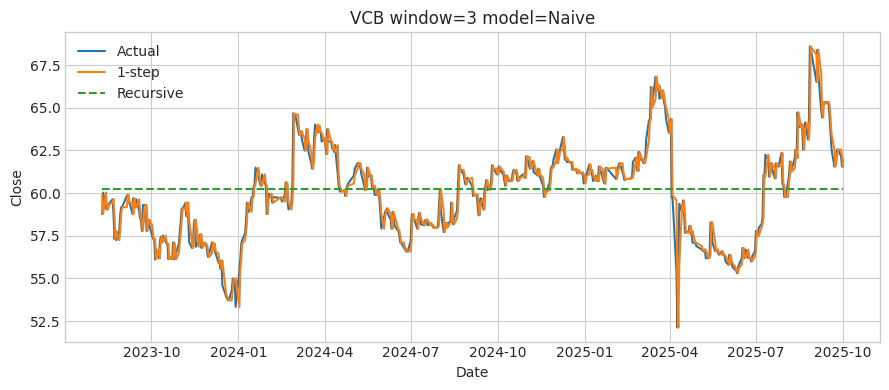

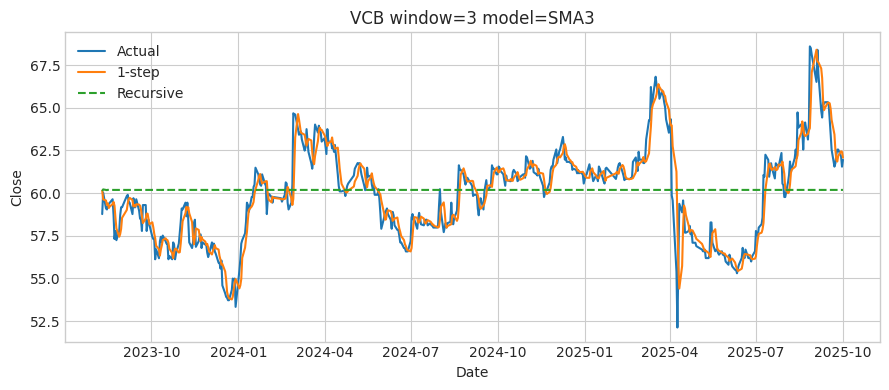

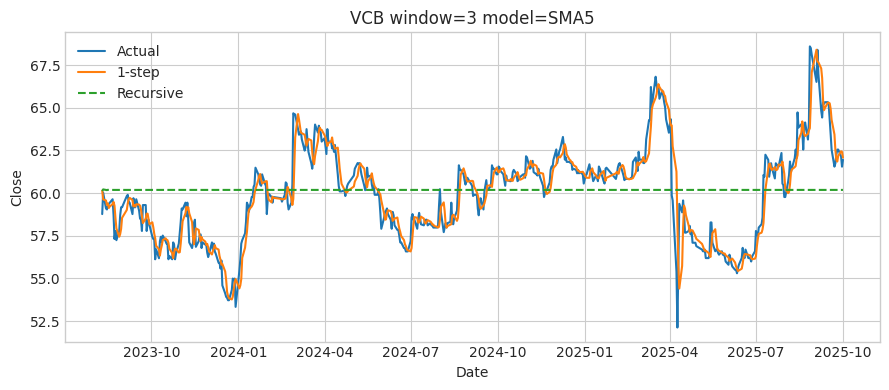

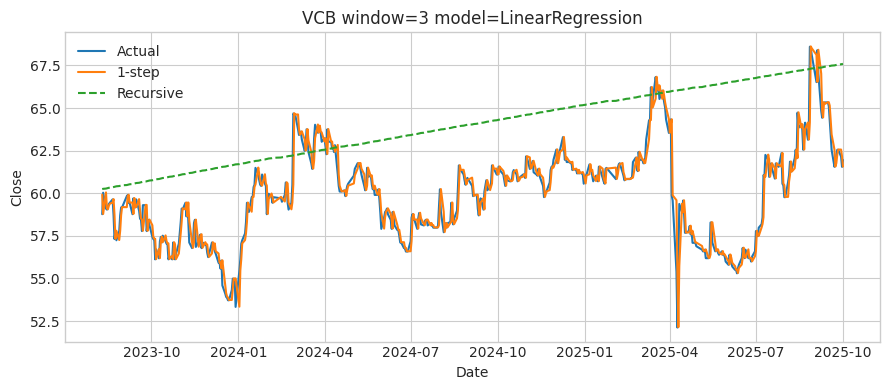

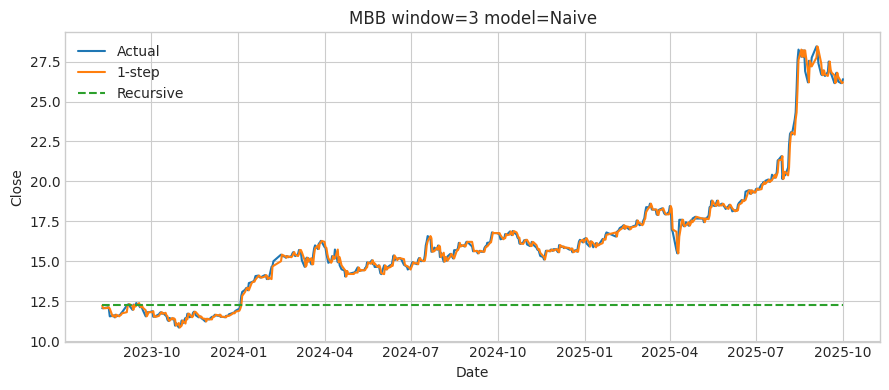

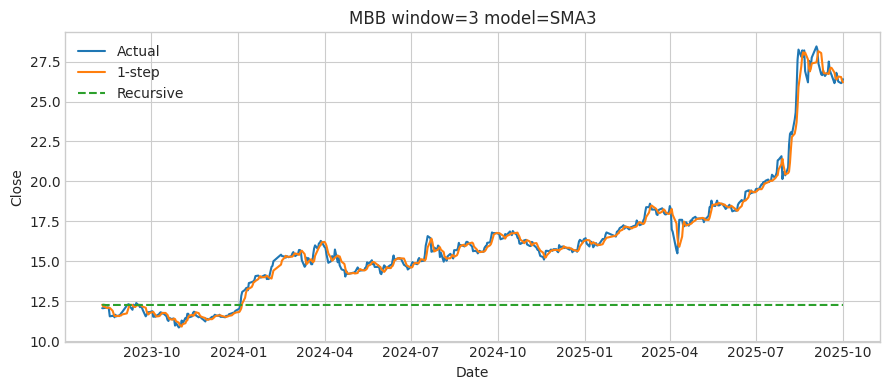

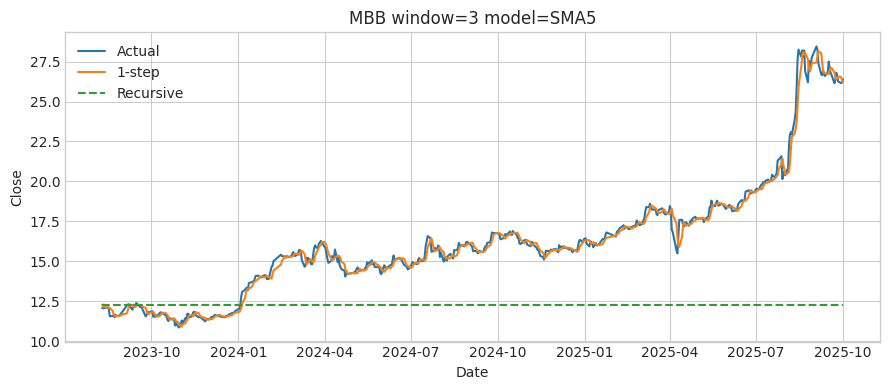

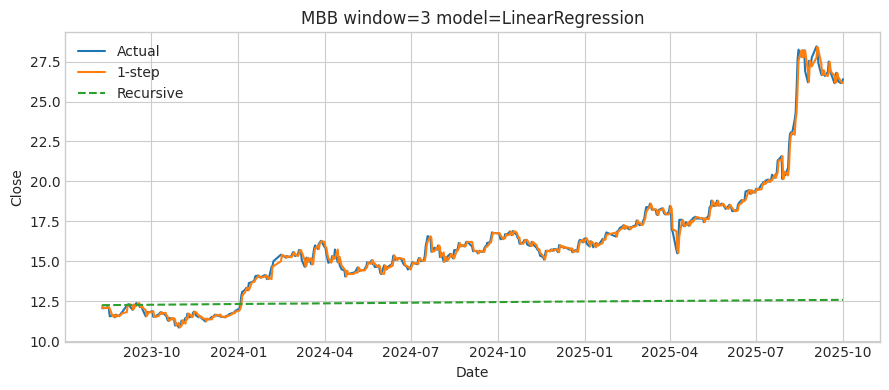

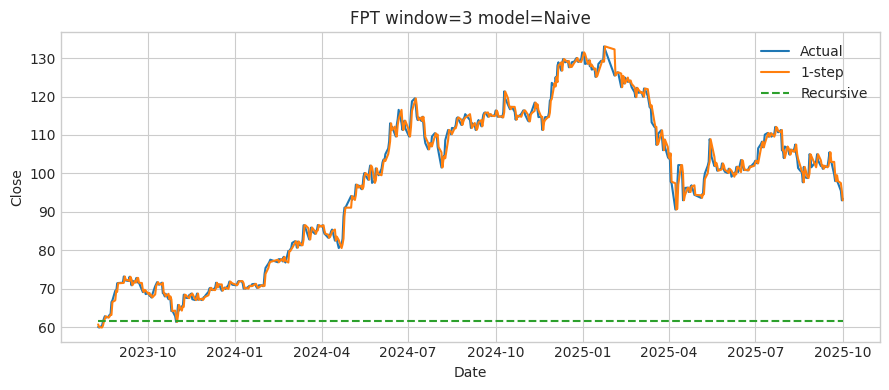

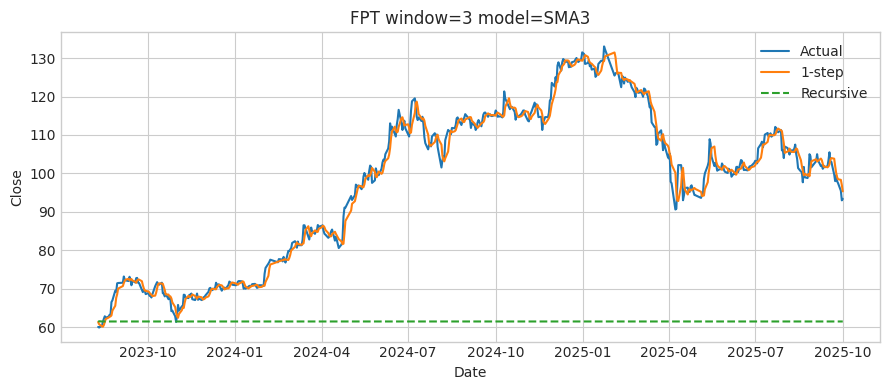

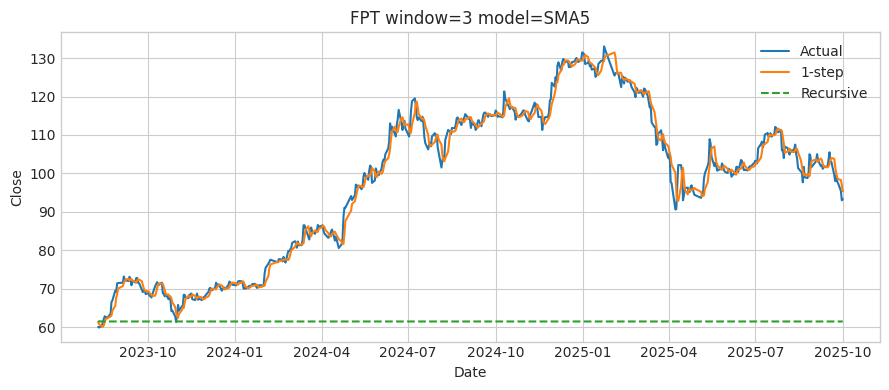

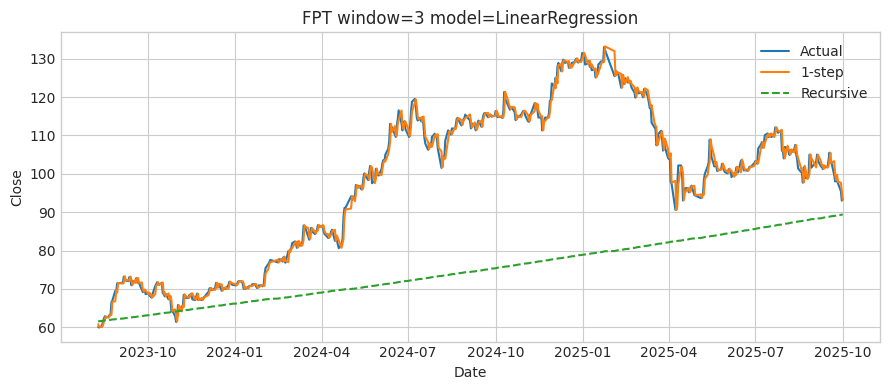

Finished training/evaluation.


,symbol,window,model,split,mae,rmse,mape
0,ACB,3,HistGradientBoosting,test,3.426995,4.187213,15.783269
1,ACB,3,LinearRegression,test,0.181002,0.295322,0.889310
2,ACB,3,Naive,test,0.180037,0.294681,0.884878
3,ACB,3,SMA3,test,0.236461,0.372942,1.158833
4,ACB,3,SMA5,test,0.236461,0.372942,1.158833
5,ACB,7,HistGradientBoosting,test,3.390145,4.147768,15.606009
6,ACB,7,LinearRegression,test,0.182998,0.297325,0.898135
7,ACB,7,Naive,test,0.179981,0.294817,0.884086
8,ACB,7,SMA3,test,0.236179,0.372916,1.156493
9,ACB,7,SMA5,test,0.278274,0.435771,1.366626


In [5]:
# Training + forecasting loop with NaN-safe handling and in-cell plots
results = []
plots_dir = base_dir / "charts"
plots_dir.mkdir(parents=True, exist_ok=True)

max_plots_per_symbol = 4  # avoid overly long output; adjust as needed

for symbol in SYMBOLS:
    df_sym_raw = raw[raw.symbol == symbol].copy()
    df_sym_ind = ind[ind.symbol == symbol].copy()

    # choose target and date source consistently
    if len(df_sym_ind):
        target_df = df_sym_ind
    else:
        target_df = df_sym_raw

    target_series = target_df['close'].astype(float).copy()
    date_series = target_df['time'].reset_index(drop=True) if 'time' in target_df.columns else pd.Series(range(len(target_series)))

    # Fill missing target values for supervised framing; keep a note
    target_series = target_series.ffill().bfill()

    plotted_count = 0
    for window in WINDOW_SIZES:
        if len(target_series) <= window + 5:
            continue  # not enough data

        X_all, y_all = make_supervised(target_series, window)
        dates = date_series[window:].reset_index(drop=True)

        # Drop any rows that still contain NaNs (defensive)
        mask = np.isfinite(X_all).all(axis=1) & np.isfinite(y_all)
        X_all = X_all[mask]
        y_all = y_all[mask]
        dates = dates[mask]
        if len(y_all) < 10:
            continue

        # time split
        n = len(y_all)
        n_test = max(5, int(n * TEST_RATIO))
        X_train, y_train = X_all[:-n_test], y_all[:-n_test]
        X_test, y_test = X_all[-n_test:], y_all[-n_test:]
        dates_test = dates[-n_test:]

        # Define model list per window
        model_specs: List[ModelSpec] = [
            ModelSpec("Naive", {}),
            ModelSpec("SMA3", {"k": min(3, window)}),
            ModelSpec("SMA5", {"k": min(5, window)}),
        ]
        if SKLEARN_AVAILABLE:
            model_specs.append(ModelSpec("LinearRegression", {}))
        if 'HGB_AVAILABLE' in globals() and HGB_AVAILABLE:
            model_specs.append(ModelSpec("HistGradientBoosting", {}))

        for spec in model_specs:
            if spec.name == "Naive":
                model = fit_naive(X_train, y_train)
                predict_next = lambda w: pred_naive(w)
            elif spec.name.startswith("SMA"):
                model = fit_sma(X_train, y_train, k=spec.params.get("k", window))
                predict_next = lambda w, m=model: pred_sma(w, m)
            elif spec.name == "LinearRegression" and SKLEARN_AVAILABLE:
                # LR requires finite values only (already ensured), train
                model = fit_lr(X_train, y_train)
                predict_next = lambda w, m=model: pred_lr(w, m)
            elif spec.name == "HistGradientBoosting" and HGB_AVAILABLE:
                model = HistGradientBoostingRegressor(random_state=42)
                model.fit(X_train, y_train)
                predict_next = lambda w, m=model: float(m.predict(w.reshape(1, -1))[0])
            else:
                continue

            # One-step predictions on test windows (standard evaluation)
            y_pred_1 = np.array([predict_next(w) for w in X_test])
            res = {
                "symbol": symbol,
                "window": window,
                "model": spec.name,
                "split": "test",
                "mae": mae(y_test, y_pred_1),
                "rmse": rmse(y_test, y_pred_1),
                "mape": mape(y_test, y_pred_1),
            }
            results.append(res)

            # Multi-step recursive forecast over the same horizon (start from last train window)
            last_window = X_all[-n_test - 1]
            y_pred_multi = recursive_forecast(last_window, steps=n_test, predict_next_fn=predict_next)

            # Plot inside the cell and also save to disk
            fig, ax = plt.subplots(figsize=(9, 4))
            ax.plot(dates_test, y_test, label="Actual", color="#1f77b4")
            ax.plot(dates_test, y_pred_1, label="1-step", color="#ff7f0e")
            ax.plot(dates_test, y_pred_multi, label="Recursive", color="#2ca02c", linestyle="--")
            ax.set_title(f"{symbol} window={window} model={spec.name}")
            ax.set_xlabel("Date")
            ax.set_ylabel("Close")
            ax.legend(loc="best")
            fig.tight_layout()

            # Show inline
            if SHOW_PLOTS and plotted_count < max_plots_per_symbol:
                display(fig)
                plotted_count += 1
            
            # Save file
            plot_path = plots_dir / f"{symbol}_w{window}_{spec.name}.png"
            fig.savefig(plot_path, dpi=120)
            plt.close(fig)

print("Finished training/evaluation.")
res_df = pd.DataFrame(results).sort_values(["symbol", "window", "model"]).reset_index(drop=True)
res_csv = plots_dir / "baseline_results.csv"
res_df.to_csv(res_csv, index=False)
res_df.head(10)

In [6]:
res_df.head(100)

,symbol,window,model,split,mae,rmse,mape
0,ACB,3,HistGradientBoosting,test,3.426995,4.187213,15.783269
1,ACB,3,LinearRegression,test,0.181002,0.295322,0.889310
2,ACB,3,Naive,test,0.180037,0.294681,0.884878
3,ACB,3,SMA3,test,0.236461,0.372942,1.158833
4,ACB,3,SMA5,test,0.236461,0.372942,1.158833
...,...,...,...,...,...,...,...
95,MBB,90,HistGradientBoosting,test,2.243083,3.874158,11.012027
96,MBB,90,LinearRegression,test,0.195119,0.302295,1.156099
97,MBB,90,Naive,test,0.188298,0.295531,1.109522
98,MBB,90,SMA3,test,0.244726,0.396925,1.434116


In [7]:
# Show top models per symbol/window
if 'res_df' in globals():
    display_cols = ["symbol", "window", "model", "mae", "rmse", "mape"]
    best = res_df.sort_values(["symbol", "window", "mae"]).groupby(["symbol", "window"]).head(1)
    display(best[display_cols].reset_index(drop=True))
else:
    print("Run previous cells to compute results.")

,symbol,window,model,mae,rmse,mape
0,ACB,3,Naive,0.180037,0.294681,0.884878
1,ACB,7,Naive,0.179981,0.294817,0.884086
2,ACB,14,Naive,0.180452,0.295333,0.886136
3,ACB,30,Naive,0.180890,0.296043,0.887499
4,ACB,90,Naive,0.181725,0.297869,0.886485
5,BID,3,LinearRegression,0.415063,0.595035,1.106202
6,BID,7,Naive,0.415749,0.595012,1.108420
7,BID,14,Naive,0.414737,0.593709,1.104955
8,BID,30,Naive,0.414367,0.594219,1.103302
9,BID,90,Naive,0.412766,0.590717,1.094849


### Optional: install extra libraries
If you want to extend beyond baselines, install scikit-learn and gradient boosting libs. In notebooks this may require a restart after installation.

- scikit-learn (LinearRegression, RandomForest, SVR, etc.)
- xgboost, lightgbm, catboost (gradient boosting)
- pytorch or tensorflow/keras (for LSTM/GRU/Transformer)

You can run the following in a terminal if desired:

- pip install scikit-learn xgboost lightgbm catboost
- pip install torch torchvision torchaudio  # or tensorflow

Then add models in the loop similarly to LinearRegression.